In [2]:
# Pablo Exposito Matilla al415550@uji.es

In [3]:
!pip install pomegranate==0.13.0
!apt install libgraphviz-dev
!pip install pygraphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgraphviz-dev is already the newest version (2.42.2-3build2).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from pomegranate import *
import matplotlib.pyplot as plt
import seaborn
import numpy
import pygraphviz
import numpy as np
import matplotlib.pylab as plt
import math

seaborn.set_style('whitegrid')
numpy.random.seed(0)
numpy.set_printoptions(suppress=True)

***User identification for human-robot interaction***

Problem description
We want to implement Zas, a social robot, to be able to identify which user (Luke, Sara or Ruth) it is interacting with. To do so, Zas is endowed with two perceptual systems: vision (cameras) and audio (microphones). These systems are aimed at predicting the user gender (female or male) and their height (short or tall). These systems have varying reliability (low or high) due to limitations of both the sensing (low light, occlusions, noise, etc.) and the machine learning (the algorithms are efficient but not very powerful). Overall, the visual system tends to be more reliable than the audio system.
The gender estimation uses both the vision and audio modules, and its performance is very good (but not perfect) when both models are reliable. Good gender performance means there is slightly or no bias (i.e. both genders are equally likely, or almost). When both audio and visual perception have low reliability, the gender estimation tends to significantly overestimate the user to be female. When the vision system is more reliable than the audio, Zas is slightly more likely to believe that the user is male. On the contrary, when the audio is more reliable than the vision system, the female gender is predicted slightly more often.
The height estimation relies only on the visual system. Good estimation imply that both height categories (short and tall) are essentially equiprobable. Under low visual reliability, the system is prone to understimate the height.
Finally, we know that Luke is a short male, and both Ruth and Sara are tall women, and Sara likes to interact more with Zas and do so more often. Sometimes some user (a relative or friend of Luke and Sara) may approach Zas. To consider this possibility, we want Zas to be able to decide that it is just "another" user.

   Model the network
* Set the variables and CPDs
* Instantiate the model, and build the graph with nodes and edges
* Display the graph as a visual check
* Prepare the model for inferences

UI1. Read the problem description in this notebook and then develop a Bayesian Network to model this problem. First, identify the variables and how they relate one an- other. Then, make up the required probabilities values to be reasonable and compatible with the given descrip- tion. Note: Although it is generally good practice to think in “generative” terms (cause-effect relationships) when developing a Bayesian network, pay attention to the provided description to understand what is adequate or possible in this case.

In [5]:
fiabilidad_audio = DiscreteDistribution({'high-confidence': 0.4,'low-reliability': 0.6})
fiabilidad_vision = DiscreteDistribution({'high-confidence': 0.6,'low-reliability': 0.4})
#  Overall, the visual system tends to be more reliable than the audio system. 

In [6]:
genero = ConditionalProbabilityTable(
    [[ 'low-reliability', 'low-reliability', 'female', 0.8 ], #  When both audio and visual perception have low reliability, the gender 
     [ 'low-reliability', 'low-reliability', 'male', 0.2 ],   #  estimation tends to significantly overestimate the user to be female.

     [ 'low-reliability', 'high-confidence', 'female', 0.4 ], #  When the vision system is more reliable than the audio,
     [ 'low-reliability', 'high-confidence', 'male', 0.6 ],   #  Zas is slightly more likely to believe that the user is male. 

     [ 'high-confidence', 'low-reliability', 'female', 0.7 ], #  On the contrary, when the audio is more reliable than the vision system,
     [ 'high-confidence', 'low-reliability', 'male', 0.3 ],   #  he female gender is predicted slightly more often. 
     
     [ 'high-confidence', 'high-confidence', 'female', 0.52 ],
     [ 'high-confidence', 'high-confidence', 'male', 0.48 ]],
    [fiabilidad_audio, fiabilidad_vision])


altura = ConditionalProbabilityTable(
    #  Under low visual reliability, the system is prone to understimate the height. 
    [[ 'low-reliability', 'tall', 0.3 ],
     [ 'low-reliability', 'short', 0.7 ],

     [ 'high-confidence', 'tall', 0.5 ],
     [ 'high-confidence', 'short', 0.5 ]],
    [fiabilidad_vision])

In [11]:
identificacion = ConditionalProbabilityTable(
    
    # Finally, we know that Luke is a short male, and both Ruth and Sara are 
    # tall women, and Sara likes to interact more with Zas and do so more often. 
    # Sometimes some user (a relative or friend of Luke and Sara) may approach Zas.
    
    [['male', 'short', 'Luke', 0.89],
     ['male', 'tall', 'Luke', 0.05],
     ['female', 'short', 'Luke', 0.05],
     ['female', 'tall', 'Luke', 0.01],
        
     ['male', 'short', 'Sara', 0.01 * 1.05], # interact more with Zas
     ['male', 'tall', 'Sara', 0.05 * 1.05],
     ['female', 'short', 'Sara', 0.05 * 1.05],
     ['female', 'tall', 'Sara', 0.89 * 1.05],
      
     ['male', 'short', 'Ruth', 0.01],
     ['male', 'tall', 'Ruth', 0.05],
     ['female', 'short', 'Ruth', 0.05],
     ['female', 'tall', 'Ruth', 0.89],

     ['male', 'short', 'Other', 0.25 * 0.95], # sometimes
     ['male', 'tall', 'Other', 0.25 * 0.95],
     ['female', 'short', 'Other', 0.25 * 0.95],
     ['female', 'tall', 'Other', 0.25 * 0.95]],
    [genero, altura])

In [12]:
# State objects hold both the distribution, and a high level name
s_fiabilidad_audio = State(fiabilidad_audio,name='fiabilidad_audio')
s_fiabilidad_video = State(fiabilidad_vision,name='fiabilidad_vision')
s_genero = State(genero,name='genero')
s_altura = State(altura,name='altura')
s_identificacion = State(identificacion,name='identificacion')

In [13]:
# Bayesian network
model3 = BayesianNetwork("User identification for human-robot interaction")
print(model3.name)

User identification for human-robot interaction


In [14]:
model3.add_states(s_fiabilidad_audio, s_fiabilidad_video, s_genero, s_altura, s_identificacion) # order is unimportant now, but *should* be considered later
print(model3) # we can explore and check the output

User identification for human-robot interaction:{
    "class" : "State",
    "distribution" : {
        "class" : "Distribution",
        "dtype" : "str",
        "name" : "DiscreteDistribution",
        "parameters" : [
            {
                "high-confidence" : 0.4,
                "low-reliability" : 0.6
            }
        ],
        "frozen" : false
    },
    "name" : "fiabilidad_audio",
    "weight" : 1.0
}{
    "class" : "State",
    "distribution" : {
        "class" : "Distribution",
        "dtype" : "str",
        "name" : "DiscreteDistribution",
        "parameters" : [
            {
                "high-confidence" : 0.6,
                "low-reliability" : 0.4
            }
        ],
        "frozen" : false
    },
    "name" : "fiabilidad_vision",
    "weight" : 1.0
}{
    "class" : "State",
    "distribution" : {
        "class" : "Distribution",
        "name" : "ConditionalProbabilityTable",
        "table" : [
            [
                "low-reliabilit

In [15]:
# add_edge(parent,child) parent -> child
model3.add_edge(s_fiabilidad_audio,s_genero) 
model3.add_edge(s_fiabilidad_video,s_genero) 
model3.add_edge(s_fiabilidad_video,s_altura) 
model3.add_edge(s_genero, s_identificacion)
model3.add_edge(s_altura, s_identificacion)

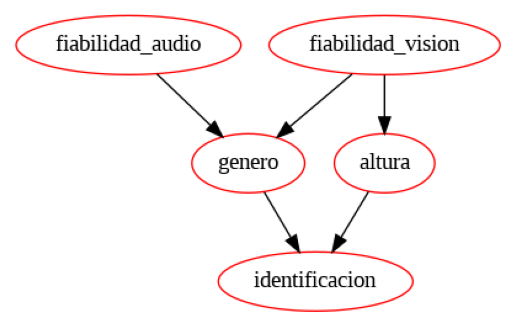

In [16]:
# draw network (graph)

model3.plot()

#print(model)

In [17]:
# Prepare for internal computations (factor graphs in BN)
model3.bake()

UI2. Assuming both sensors have low reliability and that the
estimated height is tall, what is the most likely gender
the system will estimate? Assuming this most probably
gender, who is the most likely user? What if the height
is short instead?


In [18]:
X = [[ 'low-reliability', 'low-reliability', None, 'tall', None]]
p = model3.predict_proba(X) #  matrix of posterior probabilities
print("P(Genero |low-reliability, low-reliability, tall) = ", p[0][2].parameters)
 # El genero mas probable en este caso es mujer

P(Genero |low-reliability, low-reliability, tall) =  [{'female': 0.9550587693016823, 'male': 0.04494123069831772}]


<ipython-input-18-9979df1eeb4e>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  p = model3.predict_proba(X) #  matrix of posterior probabilities


In [19]:
X = [[ 'low-reliability', 'low-reliability', None, 'short', None]]
p = model3.predict_proba([[ 'low-reliability', 'low-reliability', None, 'short', None]]) #  matrix of posterior probabilities
print("P(Genero |low-reliability, low-reliability, short) = ", p[0][2].parameters)
 # En este caso los dos generos estas muy igualados

P(Genero |low-reliability, low-reliability, short) =  [{'female': 0.5760709010339732, 'male': 0.4239290989660269}]


<ipython-input-19-652b785d7d78>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  p = model3.predict_proba([[ 'low-reliability', 'low-reliability', None, 'short', None]]) #  matrix of posterior probabilities


UI3. Given the evidence of good reliability of both perception modules and short height, what are the probabilities for each possible user, including another? How do these probabilities change if we further observe the gender and it is female? Try to make sense of these results.


In [20]:
X = [[ 'high-confidence', 'high-confidence', None, 'short', None]]
p = model3.predict_proba(X) #  matrix of posterior probabilities
print("P(User |high-confidence, high-confidence, short) = ", p[0][4].parameters)
 # El usuario mas probable es Luke

P(User |high-confidence, high-confidence, short) =  [{'Ruth': 0.04085747638756254, 'Other': 0.3150535922742226, 'Luke': 0.6011885811312742, 'Sara': 0.042900350206940656}]


<ipython-input-20-cd89b6574396>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  p = model3.predict_proba(X) #  matrix of posterior probabilities


In [21]:
X = [[ 'high-confidence', 'high-confidence', 'female', 'short', None]]
p = model3.predict_proba(X) #  matrix of posterior probabilities
print("P(User |high-confidence, high-confidence, short) = ", p[0][4].parameters)
 # El usuario mas probable es otro, ya que sabemos que ambas chicas son altas

P(User |high-confidence, high-confidence, short) =  [{'Ruth': 0.1282051282051283, 'Other': 0.6089743589743586, 'Luke': 0.1282051282051283, 'Sara': 0.13461538461538472}]


<ipython-input-21-c9579101f10c>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  p = model3.predict_proba(X) #  matrix of posterior probabilities
